<a href="https://colab.research.google.com/github/SabagYoav/Parallel-Computing/blob/main/Taxi_Drive_Cost_Estimation_for_RT_Streaming_Drives.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#spark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, exp

#general
import numpy as np

#visualization
import matplotlib.pyplot as plt
import seaborn as sns

#feature engineering
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

#ML imports
  #linear regretion
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit

#time series libraries
from pyspark.sql.functions import year, hour
from pyspark.sql.functions import col, when
from pyspark.sql.functions import concat_ws, to_timestamp

import pyspark.sql.functions as F

In [ ]:
#Build spark session
spark = SparkSession.builder.getOrCreate()

# spark is from the previous example
sc = spark.sparkContext

In [ ]:
path_to_trip_data = "Taxi Datset.csv"
df_trip = spark.read.csv(path_to_trip_data, header = True, inferSchema = True)
streaminng_schema = df_trip.schema
df_trip.show(5)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+
|       1|01/01/2020 12:28:...| 01/01/2020 12:33:...|              1|          1.2|         1|                 N|         238|         239|           1|        6.0|  3.0|    0.5|      1.47|         0.0|                  0.3

In [ ]:
print("Original df size:", df_trip.count())

df_trip = df_trip.sample(fraction = 0.5)

print("sampled df size:", df_trip.count())

Original df size: 798339
sampled df size: 399368


In [ ]:
df_trip.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: string (nullable = true)
 |-- tpep_dropoff_datetime: string (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)



In [ ]:
# deleting unwanted features
df_trip=df_trip.select(col('tpep_pickup_datetime').alias("pickup_date"), col("tpep_dropoff_datetime").alias("dropoff_date"),
                       'passenger_count','trip_distance', 'RatecodeID', 'PULocationID','DOLocationID','payment_type',
                       'fare_amount','tip_amount','tolls_amount','total_amount')

df_trip.printSchema()

root
 |-- pickup_date: string (nullable = true)
 |-- dropoff_date: string (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: integer (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- total_amount: double (nullable = true)



In [ ]:
df_trip.toPandas().isna().sum()

pickup_date          0
dropoff_date         0
passenger_count    798
trip_distance        0
RatecodeID         798
PULocationID         0
DOLocationID         0
payment_type       798
fare_amount          0
tip_amount           0
tolls_amount         0
total_amount         0
dtype: int64

In [ ]:
df_trip=df_trip.dropna(how='any', thresh=None, subset=None)
df_trip.toPandas().isna().sum()

pickup_date        0
dropoff_date       0
passenger_count    0
trip_distance      0
RatecodeID         0
PULocationID       0
DOLocationID       0
payment_type       0
fare_amount        0
tip_amount         0
tolls_amount       0
total_amount       0
dtype: int64

In [ ]:
df_trip = df_trip.withColumn("pickup_date", to_timestamp("pickup_date", "MM/dd/yyyy hh:mm:ss a"))
df_trip = df_trip.withColumn("dropoff_date", to_timestamp("dropoff_date", "MM/dd/yyyy hh:mm:ss a"))

df_trip = df_trip.sort("pickup_date")

df_trip.printSchema()

root
 |-- pickup_date: timestamp (nullable = true)
 |-- dropoff_date: timestamp (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: integer (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- total_amount: double (nullable = true)



In [ ]:
df = df_trip.filter(year(df_trip.pickup_date) == 2020)

print("Difference in number of rows:\nAll years: {}\n2020 only: {} \
      \n2020 is {}% of original database" \
      .format(df_trip.count(),df.count(),round((df.count()/df_trip.count())*100,4)))

Difference in number of rows:
All years: 398570
2020 only: 398500       
2020 is 99.9824% of original database


In [ ]:
# adding important features that we will give us insight on future analysis
df = df.withColumn('trip_duration', col('dropoff_date').cast('long')-col('pickup_date').cast('long'))
df = df.withColumn("speed_per_hour",((col('trip_distance')/col('trip_duration'))/3600))

df = df.withColumn('PU_month', F.month('pickup_date'))
df = df.withColumn('PU_day',F.date_format(df.dropoff_date,"DD"))
df = df.withColumn('PU_hour', F.hour('pickup_date'))
df = df.withColumn('weekday', F.dayofweek('pickup_date'))


df.show(20)

+-------------------+-------------------+---------------+-------------+----------+------------+------------+------------+-----------+----------+------------+------------+-------------+--------------------+--------+------+-------+-------+
|        pickup_date|       dropoff_date|passenger_count|trip_distance|RatecodeID|PULocationID|DOLocationID|payment_type|fare_amount|tip_amount|tolls_amount|total_amount|trip_duration|      speed_per_hour|PU_month|PU_day|PU_hour|weekday|
+-------------------+-------------------+---------------+-------------+----------+------------+------------+------------+-----------+----------+------------+------------+-------------+--------------------+--------+------+-------+-------+
|2020-01-01 00:00:00|2020-01-01 00:13:03|              1|          2.2|         1|          68|         170|           1|       10.5|      2.85|         0.0|       17.15|          783| 7.80473960550589E-7|       1|    01|      0|      4|
|2020-01-01 00:00:00|2020-01-01 01:45:06|       

###Outliers

In [ ]:
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

In [ ]:
# Function for plotting a scatter plot to show outliers in data
def scatter_plot(df,feature_1,feature_2):
    values_1 = df.select(feature_1).rdd.flatMap(lambda x: x).collect()
    values_2 = df.select(feature_2).rdd.flatMap(lambda x: x).collect()

    figure(figsize=(12, 5), dpi=80, linewidth=10)
    plt.scatter(x=values_1, y=values_2)
    plt.title('{} and {} in Taxi trip data'.format(feature_1,feature_2),fontsize=16)
    plt.xlabel('{}'.format(feature_1), fontsize=14)
    plt.ylabel('{}'.format(feature_2), fontsize=14)
    plt.show()

def barplot(df, col, lim=10, yname=None):
    # Grouping by the categories, counting on each categories
    # and ordering them by the count
    classes = df.groupBy(col).count().orderBy('count', ascending=False)

    # Take first 'lim' number of rows and convert to pandas
    pd_df = classes.limit(lim).toPandas()

    # Making plot
    pd_df.plot(kind='bar', x=col, legend=False)
    plt.ylabel(yname)
    plt.show()

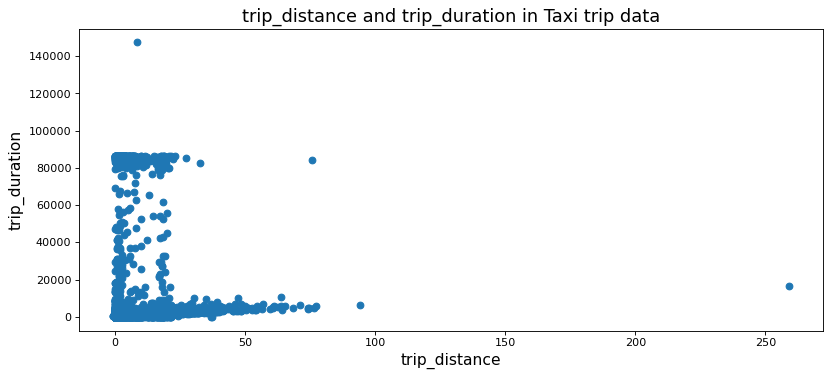

In [ ]:
#plot current df
scatter_plot(df,'trip_distance','trip_duration')

In [ ]:
# Cleaning outliers
df=df.filter((col('trip_distance')>0) & (col('trip_distance')<=100) & (col('trip_duration')>0) & (col('trip_duration')<1500))
#outlier_plot(df)

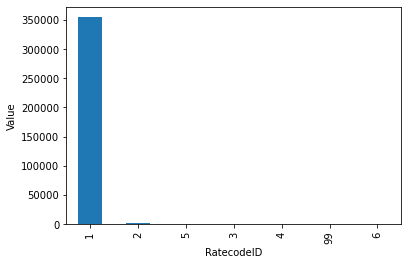

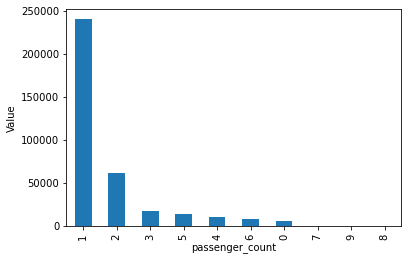

In [ ]:
barplot(df,'RatecodeID',10,'Value')
barplot(df,'passenger_count',10,'Value')

In [ ]:
df=df.filter((col('passenger_count')==1) | (col('passenger_count')==2) | (col('passenger_count')==3) | (col('passenger_count')==4))
df=df.filter(col('RatecodeID')==1)

In [ ]:
df=df.filter(col('total_amount')>0)
df=df.filter(col('fare_amount')>0)
df=df.filter(col('tip_amount')>=0)
df=df.filter(col('tolls_amount')>=0)

In [ ]:
def iqr_outlier_treatment(dataframe, columns, factor=1.5):
    for column in columns:
        # Calculate Q1, Q3, and IQR
        quantiles = dataframe.approxQuantile(column, [0.25, 0.75], 0.01)
        q1, q3 = quantiles[0], quantiles[1]
        iqr = q3 - q1

        # Define the upper and lower bounds for outliers
        lower_bound = q1 - factor * iqr
        upper_bound = q3 + factor * iqr

        # Filter outliers and update the DataFrame
        dataframe = dataframe.filter((col(column) >= lower_bound) & (col(column) <= upper_bound))

    return dataframe

In [ ]:
possible_outlier_columns= ['trip_duration','trip_distance','payment_type', 'fare_amount', 'tip_amount', 'tolls_amount', 'total_amount']
df = iqr_outlier_treatment(df, possible_outlier_columns, factor=1.5)

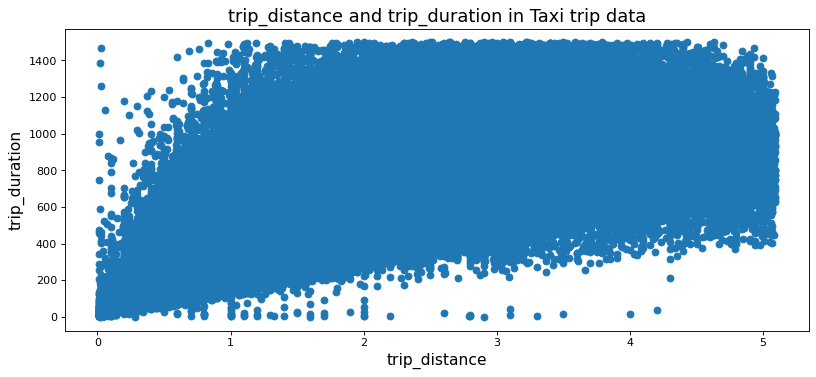

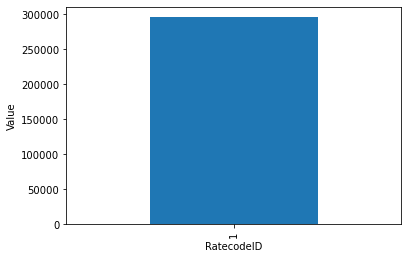

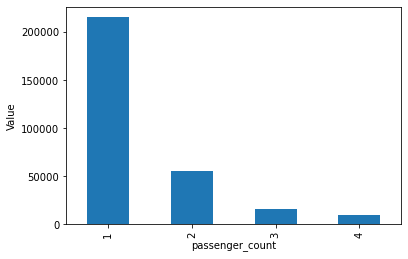

In [ ]:
scatter_plot(df,'trip_distance','trip_duration')
barplot(df,'RatecodeID',10,'Value')
barplot(df,'passenger_count',10,'Value')

time series analysis

In [ ]:
def plot_scatter(x_axis, y_axis, title, x_label, y_label):
  plt.figure(figsize=(12, 5), dpi=80, linewidth=10)
  plt.scatter(x_axis, y_axis)
  plt.title(title)
  plt.xlabel(x_label, fontsize=14)
  plt.ylabel(y_label, fontsize=14)
  plt.show()

def plot_line(x_axis, y_axis, title, x_label, y_label):
  plt.figure(figsize=(12, 5), dpi=80, linewidth=10)
  plt.plot(x_axis, y_axis)
  plt.title(title)
  plt.xlabel(x_label, fontsize=14)
  plt.ylabel(y_label, fontsize=14)
  plt.show()

def trips_average(df, avged_feature, plot_title, x_label, y_label):
    temp_df = df.groupBy('PU_hour').agg({avged_feature: 'mean'})
    temp_df = temp_df.sort('PU_hour')
    plot_line(temp_df.select('PU_hour').collect(),
              temp_df.select(temp_df.columns[1]).collect(),
              plot_title, x_label, y_label)


def trips_counter(df, feature, plot_title, x_label, y_label):
    temp_df=df.groupBy(feature).count()
    temp_df=temp_df.sort(feature)
    plot_line(temp_df.select(feature).collect(),
              temp_df.select('count').collect(),
              plot_title, x_label, y_label)

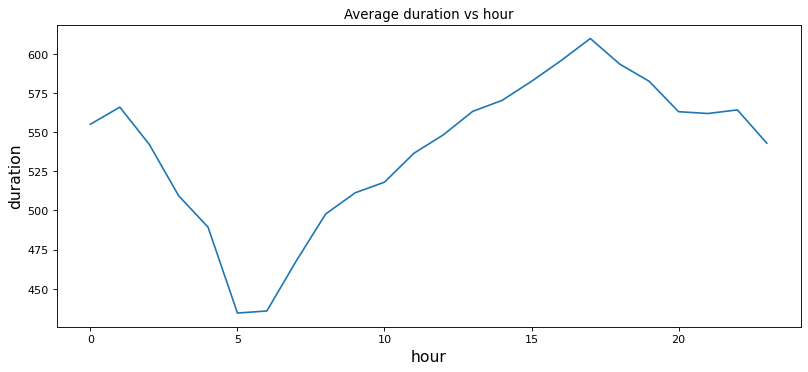

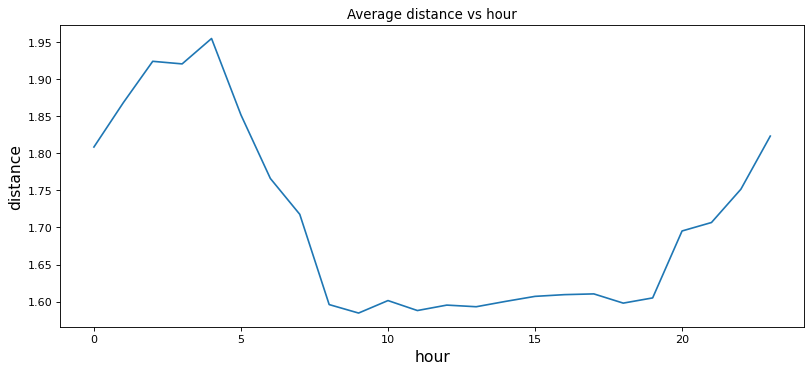

In [ ]:
trips_average(df,'trip_duration','Average duration vs hour','hour','duration')
trips_average(df,'trip_distance','Average distance vs hour','hour','distance')

#### First plot: We can see that in the morning hours (5-6) the trips taken are for longer distances
#### Second plot: Trips tend to be longer when they start around 15-17 afternoon

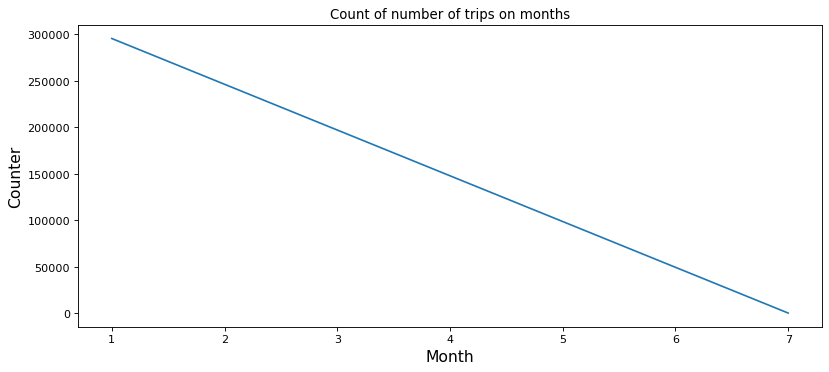

In [ ]:
trips_counter(df, 'PU_month', 'Count of number of trips on months', 'Month', 'Counter')

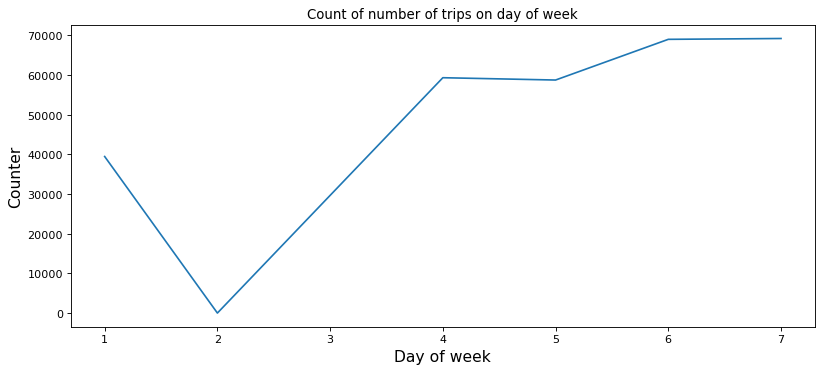

In [ ]:
trips_counter(df, 'weekday', 'Count of number of trips on day of week', 'Day of week', 'Counter')

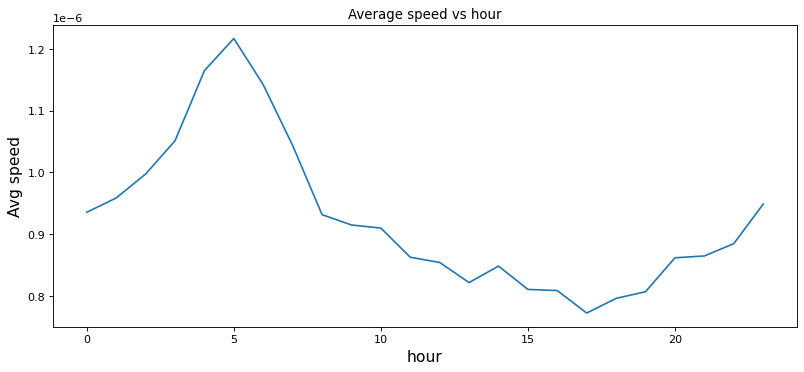

In [ ]:
trips_average(df,'speed_per_hour','Average speed vs hour','hour','Avg speed')

**We can immediately see significant drops in average speed corresponding to rush hours**

### Correlation Analisys

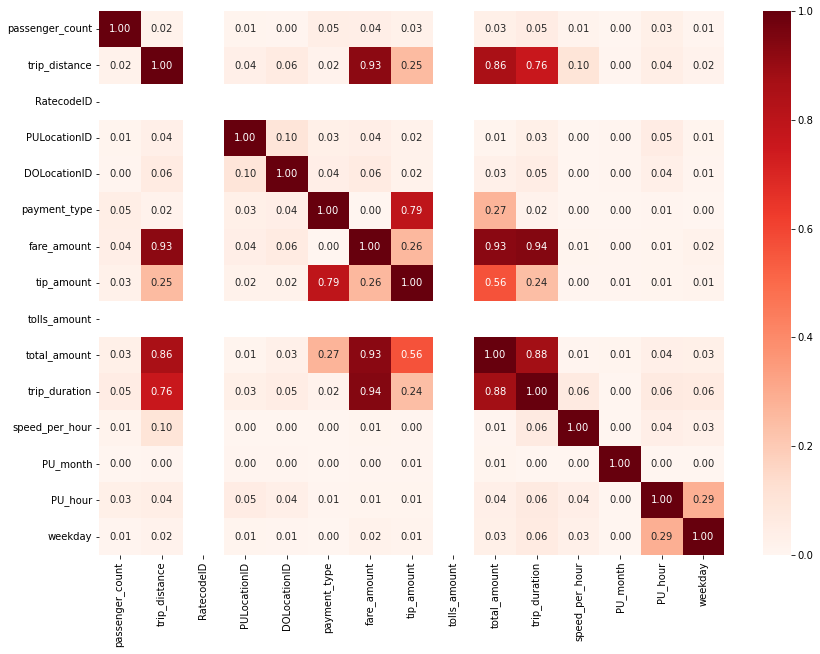

In [ ]:
def calc_and_show_heatmap(df, features):
  plt.figure(figsize=(14,10))
  corr_df = df[features]
  corr_matrix = np.abs(corr_df.corr())
  hm = sns.heatmap(corr_matrix, annot=True, cmap=plt.cm.Reds, vmin=0, vmax=1,fmt='.2f')
  plt.show()
  return corr_matrix

cor_matrix = calc_and_show_heatmap(df.toPandas(), df.columns)

In [ ]:
print('Top 5 Correlated features with "Total Amount":\n',cor_matrix.total_amount[cor_matrix.total_amount!=1].sort_values(ascending=False).head(5))

Top 5 Correlated features with "Total Amount":
 fare_amount      0.928304
trip_duration    0.878512
trip_distance    0.858146
tip_amount       0.564450
payment_type     0.269995
Name: total_amount, dtype: float64


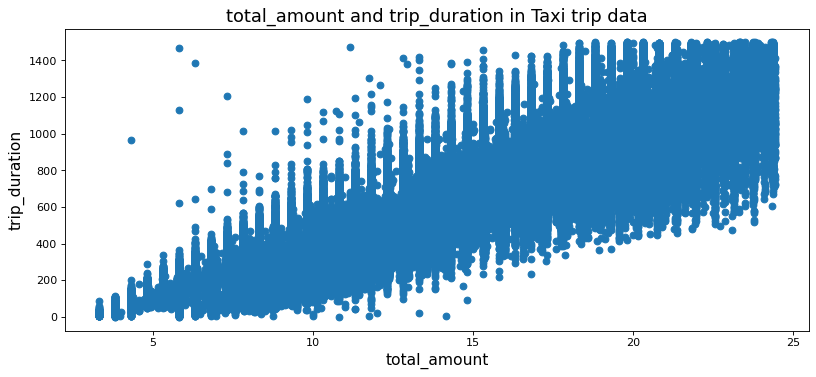

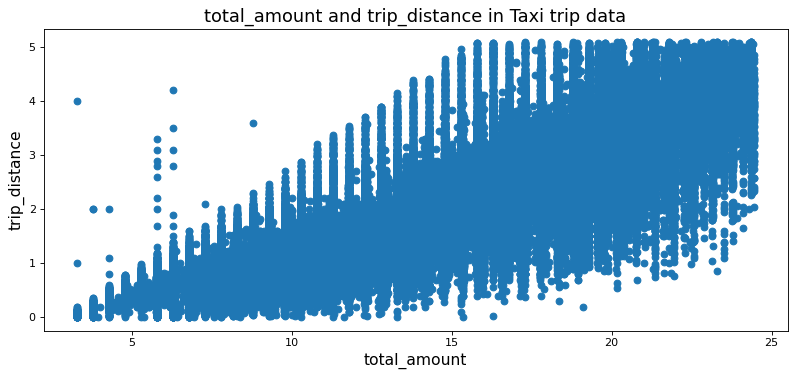

In [ ]:
scatter_plot(df,'total_amount','trip_duration')
scatter_plot(df,'total_amount','trip_distance')

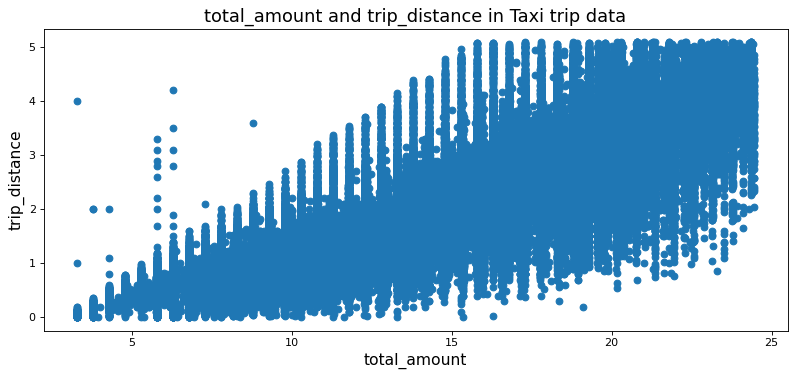

In [ ]:
scatter_plot(df,'total_amount','trip_distance')

In [ ]:
df = df.withColumn('DO_month', F.month('dropoff_date'))
df = df.withColumn('DO_day',F.date_format(df.dropoff_date,"DD"))
df = df.withColumn('DO_hour', F.hour('dropoff_date'))
df = df.withColumn('DO_minute', F.minute('dropoff_date'))
df = df.withColumn('PU_minute', F.minute('pickup_date'))


last_df=df.drop('pickup_date','dropoff_date','weekday','ratecodeID')

In [ ]:
last_df.show(5)

+---------------+-------------+------------+------------+------------+-----------+----------+------------+------------+-------------+--------------------+--------+------+-------+--------+------+-------+---------+---------+
|passenger_count|trip_distance|PULocationID|DOLocationID|payment_type|fare_amount|tip_amount|tolls_amount|total_amount|trip_duration|      speed_per_hour|PU_month|PU_day|PU_hour|DO_month|DO_day|DO_hour|DO_minute|PU_minute|
+---------------+-------------+------------+------------+------------+-----------+----------+------------+------------+-------------+--------------------+--------+------+-------+--------+------+-------+---------+---------+
|              1|          2.2|          68|         170|           1|       10.5|      2.85|         0.0|       17.15|          783| 7.80473960550589E-7|       1|    01|      0|       1|    01|      0|       13|        0|
|              1|         0.89|         236|         262|           1|        6.0|      1.96|         0.0|  

##ML Model Training and Evaluation

In [ ]:
from pyspark.ml.linalg import DenseVector
from pyspark.ml.feature import StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

In [ ]:
def df_scaler(df):
  global scaler
  input_data = df.rdd.map(lambda x: (x[0], DenseVector(x[1:])))
  # Replace `df` with the new DataFrame
  new_df = spark.createDataFrame(input_data, [df.columns[0], "features"])

  standardScaler = StandardScaler(inputCol="features", outputCol="features_scaled")
  scaler = standardScaler.fit(new_df)
  scaled_df = scaler.transform(new_df)
  return scaled_df


def LR_model (df):
  #train test split
  train, test = df.randomSplit([0.8, 0.2])

  #lr definition
  lr = LinearRegression(labelCol=df.columns[0],featuresCol=df.columns[2])
  lrModel = lr.fit(train)

  #perform prediction
  predictions = lrModel.transform(test)
  print("Intercept: %s" % str(lrModel.intercept))
  #linear model evaluation
  evaluator = RegressionEvaluator(labelCol=df.columns[0], predictionCol="prediction", metricName="rmse")
  rmse = evaluator.evaluate(predictions)
  print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

  predictions.show(10)
  return lrModel, rmse

In [ ]:
target_value='total_amount'
LR, lr_rmse = LR_model(df_scaler(last_df.select(target_value,'passenger_count','trip_distance','PULocationID','DOLocationID','payment_type',
                                     'tolls_amount','trip_duration','PU_month','PU_day','PU_hour','PU_minute','DO_month','DO_day','DO_hour','DO_minute')))

24/05/17 14:39:07 WARN Instrumentation: [9871bac1] regParam is zero, which might cause numerical instability and overfitting.
24/05/17 14:39:10 WARN Instrumentation: [9871bac1] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


Intercept: 7.643568184639764


Root Mean Squared Error (RMSE) on test data = 1.02718


+------------+--------------------+--------------------+------------------+
|total_amount|            features|     features_scaled|        prediction|
+------------+--------------------+--------------------+------------------+
|         3.3|[1.0,0.01,95.0,95...|[1.37295450255955...| 4.985173453230923|
|         3.3|[1.0,0.01,132.0,1...|[1.37295450255955...| 5.002668179832643|
|         3.3|[1.0,0.01,238.0,2...|[1.37295450255955...| 5.055859427425226|
|         3.3|[1.0,0.02,75.0,75...|[1.37295450255955...|5.0854322796092415|
|         3.3|[1.0,0.09,138.0,1...|[1.37295450255955...| 5.196442472668883|
|         3.8|[1.0,0.04,24.0,24...|[1.37295450255955...|4.9605902864401035|
|         3.8|[1.0,0.08,132.0,1...|[1.37295450255955...| 5.479719050532663|
|         3.8|[1.0,0.1,132.0,13...|[1.37295450255955...| 5.279090775545446|
|         3.8|[1.0,0.1,132.0,13...|[1.37295450255955...| 5.388666179925617|
|         3.8|[1.0,0.17,41.0,41...|[1.37295450255955...| 5.143411006030124|
+-----------

In [ ]:
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import RegressionEvaluator

In [ ]:
def decision_tree_model(df):
    #train test split
    train, test = df.randomSplit([0.8, 0.2])

    dt = DecisionTreeRegressor(labelCol=df.columns[0], featuresCol=df.columns[2])
    dt_model = dt.fit(train)

    # Make predictions on the test set
    predictions = dt_model.transform(test)

    # Evaluate RMSE
    evaluator = RegressionEvaluator(labelCol=df.columns[0], predictionCol="prediction", metricName="rmse")
    rmse = evaluator.evaluate(predictions)
    print("Root Mean Squared Error (RMSE) on test data = {:.2f}".format(rmse))
    return dt_model, rmse

In [ ]:
DT, lr_rmse = decision_tree_model(df_scaler(last_df.select(target_value,'passenger_count','trip_distance','PULocationID','DOLocationID','payment_type',
                                     'tolls_amount','trip_duration','PU_month','PU_day','PU_hour','PU_minute','DO_month','DO_day','DO_hour','DO_minute')))

+------------+--------------------+--------------------+
|total_amount|            features|     features_scaled|
+------------+--------------------+--------------------+
|       17.15|[1.0,2.2,68.0,170...|[1.37295450255955...|
|       11.76|[1.0,0.89,236.0,2...|[1.37295450255955...|
|       12.36|[2.0,0.94,90.0,17...|[2.74590900511910...|
|        8.76|[1.0,0.32,158.0,1...|[1.37295450255955...|
|         8.3|[1.0,1.7,145.0,17...|[1.37295450255955...|
|        10.3|[1.0,0.46,79.0,10...|[1.37295450255955...|
|       21.96|[1.0,3.49,48.0,26...|[1.37295450255955...|
|        10.3|[1.0,1.39,236.0,2...|[1.37295450255955...|
|        10.8|[3.0,2.02,41.0,75...|[4.11886350767866...|
|         9.3|[1.0,0.75,142.0,5...|[1.37295450255955...|
+------------+--------------------+--------------------+
only showing top 10 rows



Root Mean Squared Error (RMSE) on test data = 1.21


# Streaming


In [ ]:
#This function preprocess the new batch of streaming data

def preprocess(df):
    df=df.select(col('tpep_pickup_datetime').alias("pickup_date"), col("tpep_dropoff_datetime").alias("dropoff_date"),
                       'passenger_count','trip_distance', 'RatecodeID', 'PULocationID','DOLocationID','payment_type',
                       'fare_amount','tip_amount','tolls_amount','total_amount')

    df = df.withColumn("pickup_date", to_timestamp("pickup_date", "MM/dd/yyyy hh:mm:ss a"))
    df = df.withColumn("dropoff_date", to_timestamp("dropoff_date", "MM/dd/yyyy hh:mm:ss a"))

    df = df.withColumn('trip_duration', col('dropoff_date').cast('long')-col('pickup_date').cast('long'))
    df = df.withColumn("speed_per_hour",((col('trip_distance')/col('trip_duration'))/3600))

    df = df.withColumn('PU_month', F.month('pickup_date'))
    df = df.withColumn('PU_day',F.date_format(df.dropoff_date,"DD"))
    df = df.withColumn('PU_hour', F.hour('pickup_date'))
    df = df.withColumn('weekday', F.dayofweek('pickup_date'))

    df = df.withColumn('DO_month', F.month('dropoff_date'))
    df = df.withColumn('DO_day',F.date_format(df.dropoff_date,"DD"))
    df = df.withColumn('DO_hour', F.hour('dropoff_date'))
    df = df.withColumn('DO_minute', F.minute('dropoff_date'))
    df = df.withColumn('PU_minute', F.minute('pickup_date'))


    df=df.drop('pickup_date','dropoff_date','weekday','ratecodeID')

    df = df.select(target_value,'passenger_count','trip_distance','PULocationID','DOLocationID','payment_type',
                                     'tolls_amount','trip_duration','PU_month','PU_day','PU_hour','PU_minute','DO_month','DO_day','DO_hour','DO_minute')

    return df

In [ ]:
#The following function employ the linear regration over the new data and presents the predictions

def predict(df, batch_id):
    print("###############################################")
    print("batch ID: ", batch_id)
    #new streaming data preprocessing
    processed_df = preprocess(df)

    #scaling sreaming data
    input_data = processed_df.rdd.map(lambda x: (x[0], DenseVector(x[1:])))
    new_df = spark.createDataFrame(input_data, [processed_df.columns[0], "features"])
    standardScaler = StandardScaler(inputCol="features", outputCol="features_scaled")
    scaled_df = scaler.transform(new_df)

    #predincting streaming data target
    pred = LR.transform(scaled_df)
    #show predictions
    pred.show()

In [ ]:
#input steaming data
stream_df = spark.readStream.format("csv").schema(streaminng_schema)\
            .option("header",True).option("maxFilesPerTrigger",1)\
            .load(r"/home/linuxu/Desktop/project_setup/Streaming_Data")

stream_df.isStreaming

#activation of +predict+ function over the new stream data batch
query = stream_df.writeStream.foreachBatch(predict).outputMode('append').start()

24/05/17 15:09:50 WARN ResolveWriteToStream: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-ece83a70-87d5-4c68-be4e-28ceca0b42d1. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.
24/05/17 15:09:50 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.


###############################################
batch ID:  0


+------------+--------------------+--------------------+------------------+
|total_amount|            features|     features_scaled|        prediction|
+------------+--------------------+--------------------+------------------+
|       11.27|[1.0,1.2,238.0,23...|[1.37295450255955...| 11.34764790078843|
|        12.3|[1.0,1.2,239.0,23...|[1.37295450255955...|12.512049543674575|
|        10.8|[1.0,0.6,238.0,23...|[1.37295450255955...|10.915437512311701|
|        8.16|[1.0,0.8,238.0,15...|[1.37295450255955...|10.592830415166226|
|         4.8|[1.0,0.0,193.0,19...|[1.37295450255955...|  5.83221469520175|
|         3.8|[1.0,0.03,7.0,193...|[1.37295450255955...| 5.099871526161365|
|        3.81|[1.0,0.0,193.0,19...|[1.37295450255955...| 7.079010998545127|
|        2.81|[1.0,0.0,193.0,19...|[1.37295450255955...| 2.986936357435326|
|         6.3|[4.0,0.0,193.0,19...|[5.49181801023821...| 2.985356914960473|
|       14.15|[2.0,0.7,246.0,48...|[2.74590900511910...|13.331486775932763|
|       17.5

+------------+--------------------+--------------------+------------------+
|total_amount|            features|     features_scaled|        prediction|
+------------+--------------------+--------------------+------------------+
|       11.27|[1.0,1.2,238.0,23...|[1.37295450255955...| 11.34764790078843|
|        12.3|[1.0,1.2,239.0,23...|[1.37295450255955...|12.512049543674575|
|        10.8|[1.0,0.6,238.0,23...|[1.37295450255955...|10.915437512311701|
|        8.16|[1.0,0.8,238.0,15...|[1.37295450255955...|10.592830415166226|
|         4.8|[1.0,0.0,193.0,19...|[1.37295450255955...|  5.83221469520175|
|         3.8|[1.0,0.03,7.0,193...|[1.37295450255955...| 5.099871526161365|
|        3.81|[1.0,0.0,193.0,19...|[1.37295450255955...| 7.079010998545127|
|        2.81|[1.0,0.0,193.0,19...|[1.37295450255955...| 2.986936357435326|
|         6.3|[4.0,0.0,193.0,19...|[5.49181801023821...| 2.985356914960473|
|       14.15|[2.0,0.7,246.0,48...|[2.74590900511910...|13.331486775932763|
|       17.5

+------------+--------------------+--------------------+------------------+
|total_amount|            features|     features_scaled|        prediction|
+------------+--------------------+--------------------+------------------+
|       11.27|[1.0,1.2,238.0,23...|[1.37295450255955...| 11.34764790078843|
|        12.3|[1.0,1.2,239.0,23...|[1.37295450255955...|12.512049543674575|
|        10.8|[1.0,0.6,238.0,23...|[1.37295450255955...|10.915437512311701|
|        8.16|[1.0,0.8,238.0,15...|[1.37295450255955...|10.592830415166226|
|         4.8|[1.0,0.0,193.0,19...|[1.37295450255955...|  5.83221469520175|
|         3.8|[1.0,0.03,7.0,193...|[1.37295450255955...| 5.099871526161365|
|        3.81|[1.0,0.0,193.0,19...|[1.37295450255955...| 7.079010998545127|
|        2.81|[1.0,0.0,193.0,19...|[1.37295450255955...| 2.986936357435326|
|         6.3|[4.0,0.0,193.0,19...|[5.49181801023821...| 2.985356914960473|
|       14.15|[2.0,0.7,246.0,48...|[2.74590900511910...|13.331486775932763|
|       17.5

+------------+--------------------+--------------------+------------------+
|total_amount|            features|     features_scaled|        prediction|
+------------+--------------------+--------------------+------------------+
|       11.27|[1.0,1.2,238.0,23...|[1.37295450255955...| 11.34764790078843|
|        12.3|[1.0,1.2,239.0,23...|[1.37295450255955...|12.512049543674575|
|        10.8|[1.0,0.6,238.0,23...|[1.37295450255955...|10.915437512311701|
|        8.16|[1.0,0.8,238.0,15...|[1.37295450255955...|10.592830415166226|
|         4.8|[1.0,0.0,193.0,19...|[1.37295450255955...|  5.83221469520175|
|         3.8|[1.0,0.03,7.0,193...|[1.37295450255955...| 5.099871526161365|
|        3.81|[1.0,0.0,193.0,19...|[1.37295450255955...| 7.079010998545127|
|        2.81|[1.0,0.0,193.0,19...|[1.37295450255955...| 2.986936357435326|
|         6.3|[4.0,0.0,193.0,19...|[5.49181801023821...| 2.985356914960473|
|       14.15|[2.0,0.7,246.0,48...|[2.74590900511910...|13.331486775932763|
|       17.5

**Work Summary**

In this course project, our goal is to predict taxi total drive cost. We processed and predicted data concurrently to illustrate the handling of large streaming datasets. Initially, we analyzed past taxi drive data, examining features, correlations, and conducting time series analysis.

Subsequently, we employed feature engineering techniques to optimize our data for model training. This involved transforming time variables into timestamps, calculating drive durations, and normalizing the data. We then trained a linear regression model and evaluated its performance.

Finally, we implemented a streaming process to feed real-time drive data into our trained model for cost estimation. To enhance performance, we incorporated reinforcement learning, updating the model with the most relevant data every batch of drives.

**Results**

The trained linear model achieved an RMSE (Root Mean Squared Error) of 1.02718, which is satisfactory for our purposes. Additionally, we trained a decision tree model for comparison, which yielded an RMSE of 1.21. This model proved to be less adaptable than the linear regression model.